# 台灣銀行牌告匯率爬蟲練習
## 範例1： 練習爬取台幣對其他貨幣匯率資料

In [1]:
import requests
from bs4 import BeautifulSoup
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt

### 進入台灣銀行牌告匯率網頁：https://rate.bot.com.tw/xrt?Lang=zh-TW ，擷取當日台幣對美金的匯率資訊

In [2]:
# 進入台灣銀行牌告匯率網頁，查看當日匯率資料
url = "https://rate.bot.com.tw/xrt?Lang=zh-TW"
resp = requests.get(url)
resp.encoding = 'utf-8'
# print(resp.text)  # 如有需要，列印出網頁原始碼

html = BeautifulSoup(resp.text, "lxml")
rate_table = html.find(name='table', attrs={'title':'牌告匯率'}).find(name='tbody').find_all(name='tr')

# 查詢美金(也就是匯率表的第一個元素)對台幣的匯率
currency = rate_table[0].find(name='div', attrs={'class':'visible-phone print_hide'})
print(currency.get_text().replace(" ", ""))  # 去掉空白

buy_rate = rate_table[0].find(name='td', attrs={'data-table':'本行現金買入'})
sell_rate = rate_table[0].find(name='td', attrs={'data-table':'本行現金賣出'})
print("即時現金買入: %s, 即時現金賣出: %s" % (buy_rate.get_text(), sell_rate.get_text()))


美金(USD)

即時現金買入: 29.27, 即時現金賣出: 29.94


### 作業part 1：請參考上面的範例，試著爬取所有貨幣對台幣的匯率

In [4]:
for c in rate_table:
    print(c.find('div', {'class':'visible-phone print_hide'}).text.replace(' ', ''))
    print('即時現金買入: ', c.find('td', {'data-table':'本行現金買入'}).text, 
          '即時現金賣出: ', c.find('td', {'data-table':'本行現金賣出'}).text)


美金(USD)

即時現金買入:  29.27 即時現金賣出:  29.94

港幣(HKD)

即時現金買入:  3.672 即時現金賣出:  3.876

英鎊(GBP)

即時現金買入:  36.41 即時現金賣出:  38.53

澳幣(AUD)

即時現金買入:  20.15 即時現金賣出:  20.93

加拿大幣(CAD)

即時現金買入:  21.49 即時現金賣出:  22.4

新加坡幣(SGD)

即時現金買入:  20.78 即時現金賣出:  21.69

瑞士法郎(CHF)

即時現金買入:  30.7 即時現金賣出:  31.9

日圓(JPY)

即時現金買入:  0.2681 即時現金賣出:  0.2809

南非幣(ZAR)

即時現金買入:  - 即時現金賣出:  -

瑞典幣(SEK)

即時現金買入:  2.83 即時現金賣出:  3.35

紐元(NZD)

即時現金買入:  18.77 即時現金賣出:  19.62

泰幣(THB)

即時現金買入:  0.8301 即時現金賣出:  1.0201

菲國比索(PHP)

即時現金買入:  0.5179 即時現金賣出:  0.6509

印尼幣(IDR)

即時現金買入:  0.00178 即時現金賣出:  0.00248

歐元(EUR)

即時現金買入:  32.9 即時現金賣出:  34.24

韓元(KRW)

即時現金買入:  0.02305 即時現金賣出:  0.02695

越南盾(VND)

即時現金買入:  0.0009 即時現金賣出:  0.0014

馬來幣(MYR)

即時現金買入:  5.855 即時現金賣出:  7.48

人民幣(CNY)

即時現金買入:  4.098 即時現金賣出:  4.26


## 範例2：爬取一個月的美金對台幣歷史匯率資料，並畫出趨勢圖


美金(USD)



<Figure size 720x576 with 0 Axes>

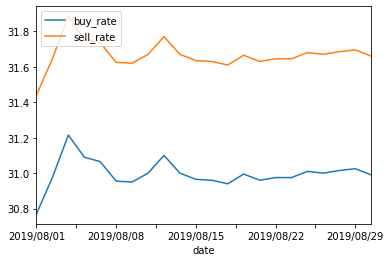

In [5]:
# 先到牌告匯率首頁，爬取所有貨幣的種類
url = "https://rate.bot.com.tw/xrt?Lang=zh-TW"
resp = requests.get(url)
resp.encoding = 'utf-8'
html = BeautifulSoup(resp.text, "lxml")
rate_table = html.find(name='table', attrs={'title':'牌告匯率'}).find(name='tbody').find_all(name='tr')

# 擷取匯率表格，把美金(也就是匯率表的第一個元素)擷取出來，查詢其歷史匯率
currency = rate_table[0].find(name='div', attrs={'class':'visible-phone print_hide'})
print(currency.get_text().replace(" ", ""))  # 貨幣種類

# 針對美金，找到其「歷史匯率」的首頁 
history_link = rate_table[0].find(name='td', attrs={'data-table':'歷史匯率'})
history_rate_link = "https://rate.bot.com.tw" + history_link.a["href"]  # 該貨幣的歷史資料首頁

#
# 到貨幣歷史匯率網頁，選則該貨幣的「歷史區間」，送出查詢後，觀察其網址變化情形，再試著抓取其歷史匯率資料
#
# 用「quote/年-月」去取代網址內容，就可以連到該貨幣的歷史資料
quote_history_url = history_rate_link.replace("history", "quote/2019-08")
resp = requests.get(quote_history_url)
resp.encoding = 'utf-8'
history = BeautifulSoup(resp.text, "lxml")
history_table = history.find(name='table', attrs={'title':'歷史本行營業時間牌告匯率'}).find(name='tbody').find_all(name='tr')

#
# 擷取到歷史匯率資料後，把資料彙整起來並畫出趨勢圖
#
date_history = list()
history_buy = list()
history_sell = list()

for history_rate in history_table:
    # 擷取日期資料
    date_string = history_rate.a.get_text()
    date = datetime.strptime(date_string, '%Y/%M/%d').strftime('%Y/%M/%d')  # 轉換日期格式
    date_history.append(date)  # 日期歷史資料

    history_ex_rate = history_rate.find_all(name='td', attrs={'class':'rate-content-cash text-right print_table-cell'})
    history_buy.append(float(history_ex_rate[0].get_text()))  # 歷史買入匯率
    history_sell.append(float(history_ex_rate[1].get_text()))  # 歷史賣出匯率

# 將匯率資料建成dataframe形式
HistoryExchangeRate = pd.DataFrame({'date': date_history,
                                    'buy_rate':history_buy,
                                    'sell_rate':history_sell})

HistoryExchangeRate = HistoryExchangeRate.set_index('date')  # 指定日期欄位為datafram的index
HistoryExchangeRate = HistoryExchangeRate.sort_index(ascending=True)

# 畫出歷史匯率軌跡圖
plt.figure(figsize=(10, 8))
HistoryExchangeRate[['buy_rate','sell_rate']].plot()  # x=['date'], y=[['buy_rate','sell_rate']] 
plt.legend(loc="upper left")
plt.show()

### 作業part 2：爬取每種貨幣對台幣的一個月歷史匯率資料，並畫出趨勢圖


美金(USD)



<Figure size 720x576 with 0 Axes>

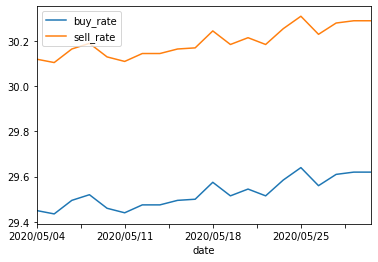


港幣(HKD)



<Figure size 720x576 with 0 Axes>

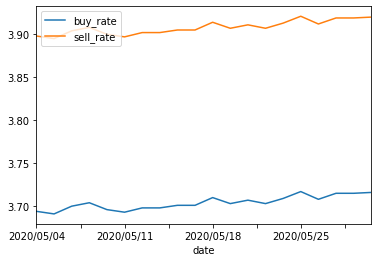


英鎊(GBP)



<Figure size 720x576 with 0 Axes>

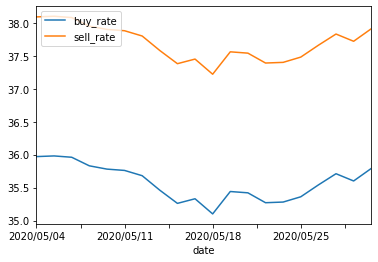


澳幣(AUD)



<Figure size 720x576 with 0 Axes>

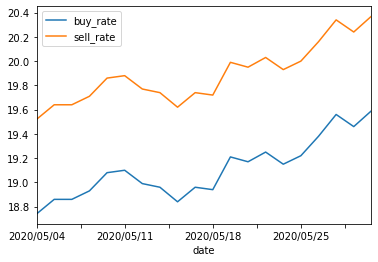


加拿大幣(CAD)



<Figure size 720x576 with 0 Axes>

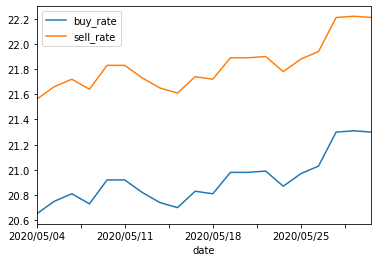


新加坡幣(SGD)



<Figure size 720x576 with 0 Axes>

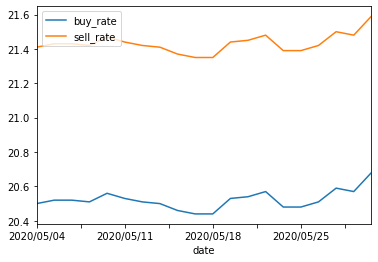


瑞士法郎(CHF)



<Figure size 720x576 with 0 Axes>

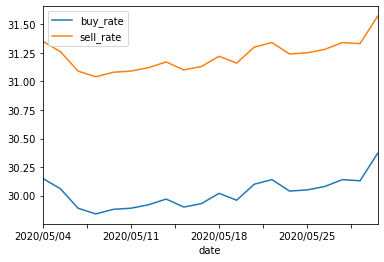


日圓(JPY)



<Figure size 720x576 with 0 Axes>

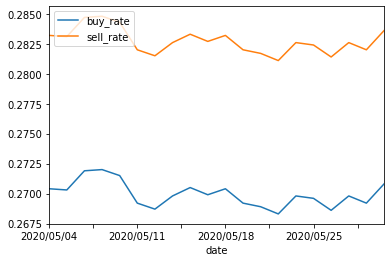


南非幣(ZAR)



<Figure size 720x576 with 0 Axes>

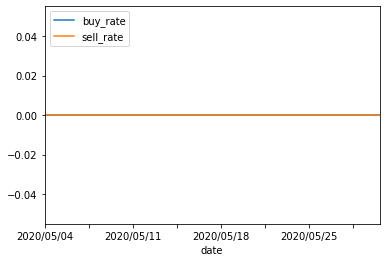


瑞典幣(SEK)



<Figure size 720x576 with 0 Axes>

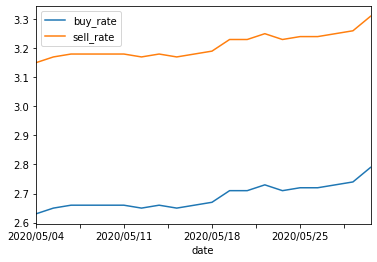


紐元(NZD)



<Figure size 720x576 with 0 Axes>

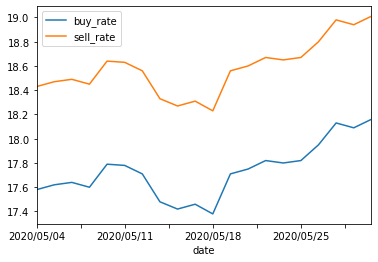


泰幣(THB)



<Figure size 720x576 with 0 Axes>

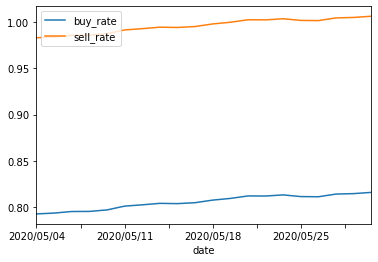


菲國比索(PHP)



<Figure size 720x576 with 0 Axes>

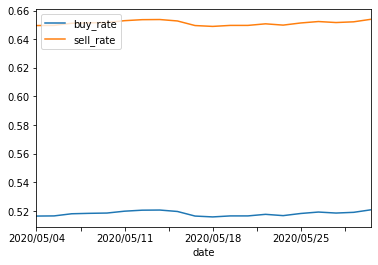


印尼幣(IDR)



<Figure size 720x576 with 0 Axes>

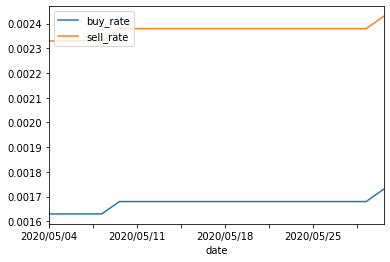


歐元(EUR)



<Figure size 720x576 with 0 Axes>

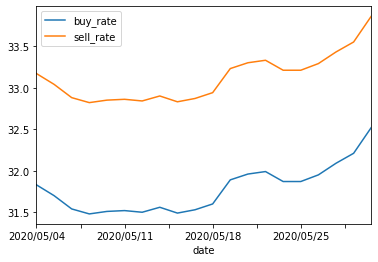


韓元(KRW)



<Figure size 720x576 with 0 Axes>

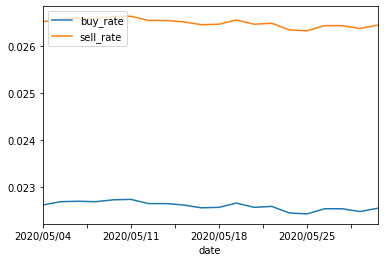


越南盾(VND)



<Figure size 720x576 with 0 Axes>

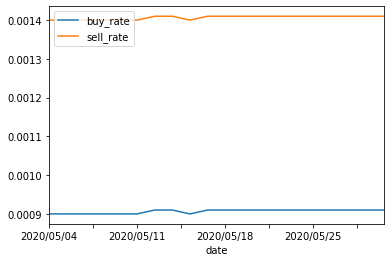


馬來幣(MYR)



<Figure size 720x576 with 0 Axes>

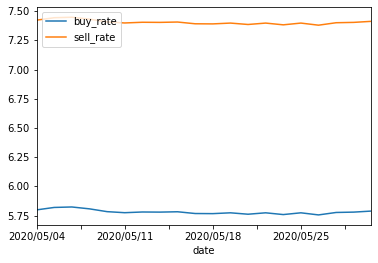


人民幣(CNY)



<Figure size 720x576 with 0 Axes>

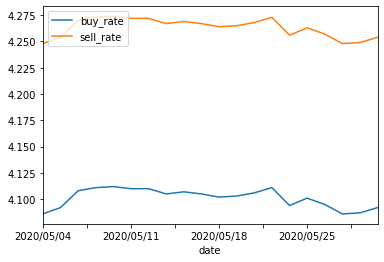

In [8]:
for c in rate_table:
    print(c.find('div', {'class':'visible-phone print_hide'}).text.replace(' ', ''))
    
    h_link = c.find('td', {'data-table':'歷史匯率'}).a['href']
    h_rate_link = ('https://rate.bot.com.tw' + h_link).replace('history', "quote/2020-05")
    
    res = requests.get(h_rate_link)
    res.encoding = 'utf-8'
    history = BeautifulSoup(res.text, 'lxml')
    history_table = history.find('table').find('tbody').find_all('tr')
    
    date_history = list()
    history_buy = list()
    history_sell = list()
    
    for h in history_table:
        date = datetime.strptime(h.a.text, '%Y/%m/%d').strftime('%Y/%m/%d')
        date_history.append(date)
        
        h_bs = h.find_all('td', {'class':'rate-content-cash text-right print_table-cell'})
        history_buy.append(float(h_bs[0].text))
        history_sell.append(float(h_bs[1].text))
    
    history_change_rate = pd.DataFrame({'date': date_history,
                                        'buy_rate': history_buy,
                                        'sell_rate': history_sell})
    
    history_change_rate = history_change_rate.set_index('date')
    history_change_rate = history_change_rate.sort_index(ascending=True)
    
    plt.figure(figsize=(10, 8))
    history_change_rate[['buy_rate','sell_rate']].plot()  # x=['date'], y=[['buy_rate','sell_rate']] 
    plt.legend(loc="upper left")
    plt.show()
    